In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
folder = 'npy_aves/Embeddings/'
full_name = "enabirds_aves_lr0.0001_epoch6_features"
species = full_name.split("_")[0]
# Split the string into a list of words
words = full_name.split("_")
# Select from the 2nd word to the 2nd to the last word
selected_words = words[1:-1]
# Join the selected words back into a string
nn_model = "_".join(selected_words)
# nn_model = 'swin-pretrained_lr0.0001_epoch11'
X=np.load(folder+species+'_'+nn_model+'_features.npy') # total batches and feature dimensions
X_labels = np.load(folder+species+'_'+nn_model+'_labels.npy')
if len(X_labels.shape) > 1: # detection task with one-hot encoder 0-1-0
    X_labels = np.argmax(X_labels, axis=1)
N_class = len(np.unique(X_labels))
N_sample = len(X_labels)


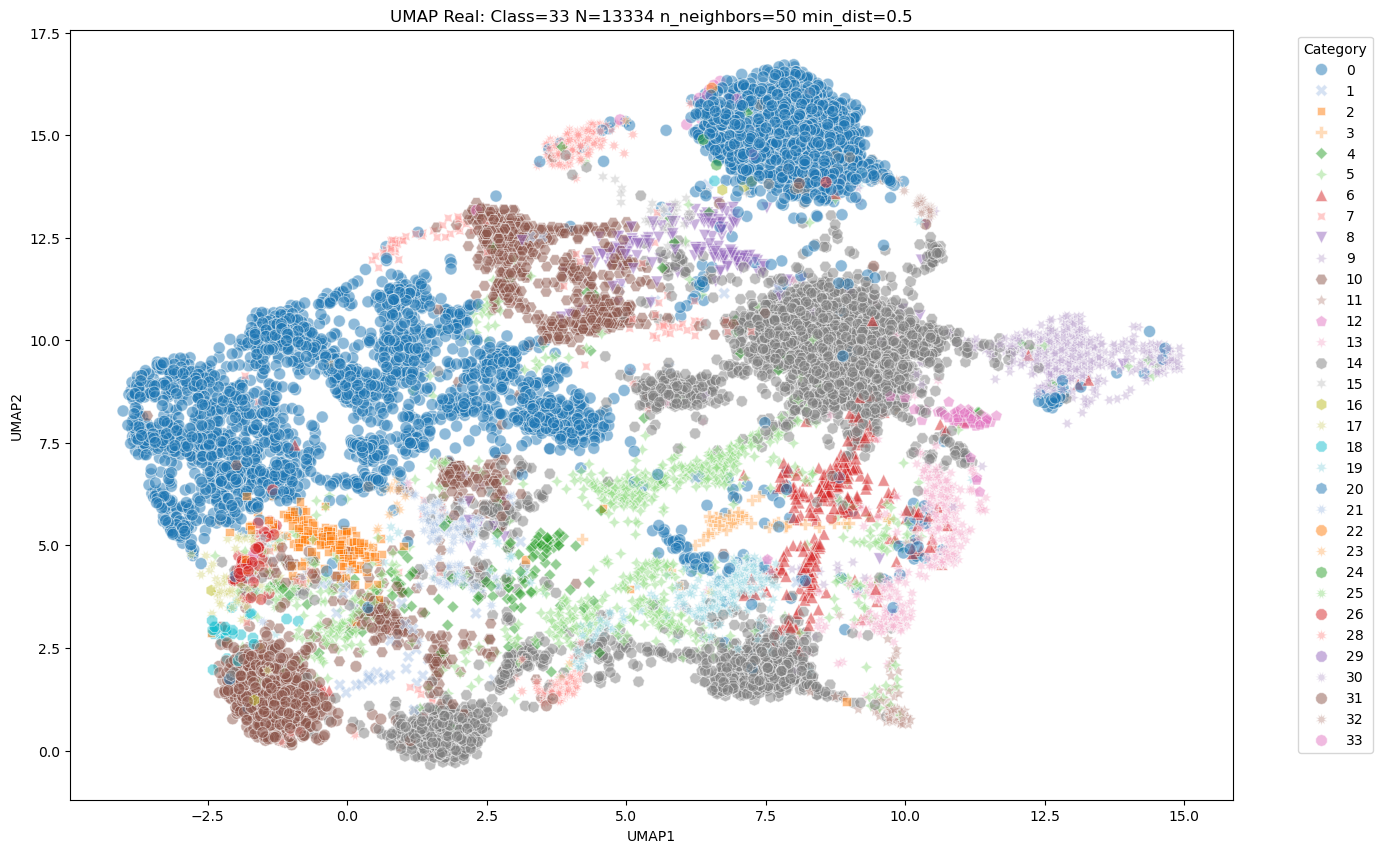

In [21]:
import umap
# n_neighbors controls the balance between local and global structure in the data.
    # must>1,   smaller==more scatter and less clustering
# min_dist controls how tight clusters can be.
    # 0.1 to 1, smaller== tighter & squeezed clusters
# n_components is the number of dimensions you want to reduce your data to.
# random_state ensures reproducibility of your results.
n_neighbors = 50
min_dist = 0.5
umap_model = umap.UMAP(n_neighbors = n_neighbors, min_dist=min_dist, 
                       n_components=2, n_jobs=1, random_state=42)
umap_results = umap_model.fit_transform(X)  # # this step tool several seconds
### testing the clustering results before next step clustering
umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'])
umap_df['Labels'] = pd.DataFrame(X_labels)

plt.figure(figsize=(15, 10))
### show with color & shape change ###
scatter = sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2',
                          hue='Labels', style='Labels',  # Use 'Type' for style if you have a separate variable
                          palette='tab20', alpha=0.5, s = 75,
                          markers=True)  # Ensures default markers are used, can customize as needed
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('UMAP Real: Class='+str(N_class)+' N='+str(N_sample)+
          ' n_neighbors='+str(n_neighbors)+' min_dist='+str(min_dist))
    ### Save the figure with high resolution; MUST ahead of image displaying
plt.savefig(species+'_'+nn_model+'_'+'UMAP_plot.pdf', dpi=300, bbox_inches='tight') 
plt.show()

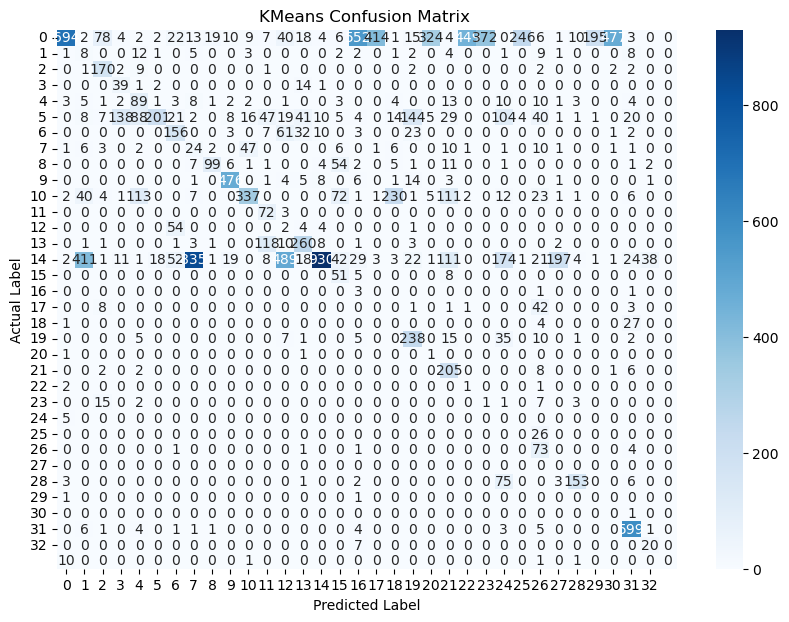

Type 0: 3999 elements accuracy=17.35433858464616
Type 1: 60 elements accuracy=13.333333333333334
Type 2: 191 elements accuracy=89.00523560209425
Type 3: 57 elements accuracy=68.42105263157895
Type 4: 166 elements accuracy=53.6144578313253
Type 5: 978 elements accuracy=20.552147239263803
Type 6: 298 elements accuracy=52.348993288590606
Type 7: 123 elements accuracy=19.51219512195122
Type 8: 195 elements accuracy=50.76923076923077
Type 9: 521 elements accuracy=91.36276391554703
Type 10: 970 elements accuracy=34.74226804123711
Type 11: 75 elements accuracy=96.0
Type 12: 65 elements accuracy=3.076923076923077
Type 13: 409 elements accuracy=63.56968215158925
Type 14: 3468 elements accuracy=26.81660899653979
Type 15: 64 elements accuracy=79.6875
Type 16: 5 elements accuracy=60.0
Type 17: 56 elements accuracy=0.0
Type 18: 32 elements accuracy=0.0
Type 19: 319 elements accuracy=74.60815047021944
Type 20: 3 elements accuracy=33.33333333333333
Type 21: 224 elements accuracy=91.51785714285714
Typ

/tmp/ipykernel_769029/751015149.py:80: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


In [19]:
### we know the groundtruch labels. 
### We want to predict the labels based on UMAP DA results with clustering method
### There are 4 clustering method with pre-designed cluster numbers
### https://scikit-learn.org/stable/modules/clustering.html#clustering
cluster_method = 'KMeans'

if cluster_method == 'HDBSCAN':
    import hdbscan # can't control the number of clusters
    # n_jobs=-1 will cause error! 
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
    clusterer.fit(umap_results)
    labels_pred = clusterer.labels_
elif cluster_method == 'KMeans':
    from sklearn.cluster import KMeans
    # Specify the number of clusters
    # From 0.23 it uses all cores by default. 
    # n_jobs=-1 will cause error!
    kmeans = KMeans(n_clusters=N_class, random_state=42) ## parallel automatically
    labels_pred = kmeans.fit_predict(umap_results)
elif cluster_method == 'GMM':
    from sklearn.mixture import GaussianMixture
    # assume the data is generated from a mixture of several Gaussian distributions with unknown parameters. 
    # GMM can accommodate clusters that have different sizes and correlation structures.
    # n_jobs=-1 will cause error!
    gmm = GaussianMixture(n_components=N_class, random_state=42)
    labels_pred = gmm.fit_predict(umap_results)
elif cluster_method == 'SC':
    from sklearn.cluster import SpectralClustering
    # uses the eigenvalues of a similarity matrix of the data to reduce dimensionality before clustering 
    # in fewer dimensions. It can capture complex cluster structures and is particularly good for non-convex clusters.
    # n_jobs=-1 works but with very low speed
    spectral = SpectralClustering(n_clusters=N_class, n_jobs=-1, random_state=42, assign_labels='discretize')
    labels_pred = spectral.fit_predict(umap_results)
elif cluster_method == 'HAC':
    from sklearn.cluster import AgglomerativeClustering
    # best for watkins dataset
    # metricstr or callable, default=”euclidean”:::“euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”
    # linkage{‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
    # for watkin dataset, 'ward'~='average'>‘complete’>‘single’
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
    # builds a hierarchy of clusters using a bottom-up approach, starting with individual data points 
    # as their own cluster and merging the closest pairs at each step. 
    # n_jobs=-1 will cause error!
    agglomerative = AgglomerativeClustering(n_clusters=N_class, linkage='ward')
    labels_pred = agglomerative.fit_predict(umap_results)

### match the sequence of predicted labels to real labels
labels_true = X_labels
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_true, labels_pred)
# The linear_sum_assignment function minimizes the cost, so to maximize the number of correct assignments,
# we need to negate the confusion matrix since higher numbers indicate better matches.
# The Hungarian algorithm finds the optimal assignment for the negated matrix.
row_ind, col_ind = linear_sum_assignment(-cm)
# Create a new array to hold the remapped predicted labels
remapped_labels_pred = np.zeros_like(labels_pred)
# Remap the predicted labels to match the true labels as closely as possible
for pred, true in zip(col_ind, row_ind):
    remapped_labels_pred[labels_pred == pred] = true
# Now, 'remapped_labels_pred' should correspond more closely to 'labels_true' in terms of label identifiers.

### plot the results
cm = confusion_matrix(labels_true, remapped_labels_pred)
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(cluster_method+" Confusion Matrix ")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.savefig(species+'_'+nn_model+'_'+'UMAP'+
            '_'+str(cluster_method)+'cluster_CM.pdf', dpi=300, bbox_inches='tight') 
    plt.show()

class_names = np.arange(N_class)  # Example: np.array(["Class 1", "Class 2", ..., "Class 31"])
plot_confusion_matrix(cm, class_names)

# Calculate the accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
class_accuracies = (class_accuracies*100)
from collections import Counter
# Assuming labels_true is your array or list of true labels
labels_count = Counter(labels_true)
# Iterating from 0 to N_class-1 and printing the number of elements for each type
for label in range(N_class):  # N_class is exclusive, so it prints 0 to N_class-1
    print(f"Type {label}: {labels_count[label]} elements accuracy="+str(class_accuracies[label]))

# Calculate the mean of the accuracies
mean_accuracy = np.nanmean(class_accuracies) #mainly for enabirds dataset
# Calculate the standard deviation of the accuracies
std_deviation = np.nanstd(class_accuracies)
# Print out the mean and standard deviation in the format mean +/- standard deviation
print(f"Mean Accuracy: {mean_accuracy:.1f}±{std_deviation:.1f}")

In [20]:
print(f"Mean Accuracy: {mean_accuracy:.1f}±{std_deviation:.1f}")
### only two inputs: labels_true, labels_pred
### No need for this (nothing change execpt Hopkins)labels_pred = remapped_labels_pred
from sklearn.metrics import adjusted_rand_score
### An ARI score of 1 indicates perfect labeling
ari_score = adjusted_rand_score(labels_true, labels_pred)
# print(f"Adjusted Rand Index: {round(ari_score, 3)}")
print(f"Adjusted Rand Index: {round(ari_score, 3)}")
from sklearn.metrics import normalized_mutual_info_score
### similarity between true and predicted labels, 0 (no mutual information) and 1 (perfect correlation).
nmi_score = normalized_mutual_info_score(labels_true, labels_pred)
print(f"Normalized Mutual Information: {round(nmi_score,3)}")
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
### Homogeneity: each cluster contains only members of a single class.
### Completeness: all members of a given class are assigned to the same cluster.
### V-Measure: the harmonic mean between homogeneity and completeness.
homogeneity = homogeneity_score(labels_true, labels_pred)
completeness = completeness_score(labels_true, labels_pred)
v_measure = v_measure_score(labels_true, labels_pred)
# print(f"Homogeneity: {homogeneity}")
# print(f"Completeness: {completeness}")
# print(f"V-Measure: {v_measure}")
from sklearn.metrics import silhouette_score
### Measures how similar an object is to its own cluster compared to other clusters.
### Ranges from -1 to 1, high value indicates object is well matched to its own cluster
### Unlike the other metrics, the Silhouette Score does not require true labels

### Ask Gemini and ChatGPT for parallel but failed or too complex
silhouette_avg = silhouette_score(X, labels_pred, n_jobs = -1)
# print(f"Silhouette Score: {round(silhouette_avg,3)}")
print(round(silhouette_avg,3))

### It measures the probability that a given dataset is generated by a uniform data distribution.
### A value close to 1 suggests the data is uniformly distributed (random)
### from sklearn.neighbors import NearestNeighbors
# def hopkins_statistic(X):
#     n, d = X.shape
#     m = int(0.1 * n)  # m points for comparison, 10% of the dataset size is a common choice
#     nbrs = NearestNeighbors(n_neighbors=1).fit(X)
#     # Generate random points for the synthetic dataset
#     random_points = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))
#     # Calculate distances of real points to their nearest neighbors
#     _, dist_real = nbrs.kneighbors(X[np.random.choice(n, m, replace=False), :])
#     # Calculate distances of random points to nearest real points
#     _, dist_random = nbrs.kneighbors(random_points)
#     H = np.sum(dist_random) / (np.sum(dist_real) + np.sum(dist_random))
#     return H
# print(f"Hopkins Statistic: {hopkins_statistic(X)}")

Mean Accuracy: 42.2±34.6
Adjusted Rand Index: 0.213
Normalized Mutual Information: 0.543
0.096
